# RNN BUILD

* Først hente og rense data ved bruk av eget lib
* Så sette opp en modell
* Trene og validere -> Deretter teste på ny data
* Lagre modellen

Ops ops: Modellen kan kun bukes på data med 3 dimensjoner. Det betyr at det alltid på komme i en sekvens på minimum (2, 30, 5)

In [36]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt
import pickle
import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from lib.rens import rens
from lib.create_dataset import create_dataset
from lib.make_ready import make_ready


In [2]:
# Pickle save and load premake file.
#import pickle
#with open('premade_data/79dager.pkl', 'wb') as f:
#    pickle.dump(data, f)
    
# Load
with open('premade_data/79dager.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
def r2_score_nn(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def add_data(word):
    ordet = 'data/' + word
    return ordet

In [6]:
indikatorer = ['macd', 'rsi_6', 'rsi_10', 'rsi_20', 'rsi_60', 
               'open_4_sma', 'open_8_sma', 'open_15_sma', 'open_16_sma', 'open_30_sma', 'open_60_sma',
               'trix', 'open_10_trix', 'open_30_trix', 'open_60_trix', 
               'wr_10', 'wr_20', 'wr_60', 'open_30_mstd', 'vr_30_sma',
               'volume', 'dma', 'atr_30', 'adx_30_ema', 'adx', 'adxr', 'cci_30']

In [6]:
#len(os.listdir('data/')) # sjekk antall filer
filer = list(map(add_data, os.listdir('data/')))[0:2] # test 54:60 mellom 10 og 14 er noe feil
data = make_ready().use_stockstats(filer)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [7]:
data[0]

,tid,open,close,high,low,volume,amount,close_-1_s,close_-1_d,rs_20,...,open_16_sma,macd,macds,macdh,open_30_sma,open_15_sma,sma8-16,sma30_derivert,sma15_derivert,derivert
0,9:0,239.0,239.0,239.0,239.0,5179,5179,244.862234,0.005319,1.169436,...,239.000000,0.000000,0.000000,0.000000,239.000000,239.000000,0.0000,1.000000,1.000000,1.000000
1,9:1,239.2,239.2,239.2,239.2,180,180,239.000000,0.200000,1.169436,...,239.100000,0.004487,0.002493,0.001994,239.100000,239.100000,0.0000,1.000000,1.000000,1.000000
2,9:2,241.0,241.0,241.0,241.0,2396,2396,239.200000,1.800000,1.169436,...,239.733333,0.061535,0.026691,0.034845,239.733333,239.733333,0.0000,1.002649,1.002649,1.007525
3,9:3,242.2,242.2,242.2,242.2,3733,3733,241.000000,1.200000,1.169436,...,240.350000,0.129300,0.061450,0.067850,240.350000,240.350000,0.0000,1.002572,1.002572,1.004979
4,9:4,245.2,245.2,245.2,245.2,2865,2865,242.200000,3.000000,1.169436,...,241.320000,0.282776,0.127289,0.155487,241.320000,241.320000,0.0000,1.004036,1.004036,1.012386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,16:16,240.4,240.4,240.4,240.4,14,14,240.200000,0.200000,1.137037,...,240.187500,0.254409,0.255595,-0.001187,239.526667,240.200000,0.2125,1.000278,1.000111,1.000833
373,16:17,240.4,240.4,240.4,240.4,2320,2320,240.400000,0.000000,1.137037,...,240.212500,0.251285,0.254733,-0.003448,239.580000,240.213333,0.1375,1.000223,1.000056,1.000000
374,16:18,240.4,240.4,240.4,240.4,433,433,240.400000,0.000000,1.137037,...,240.225000,0.245974,0.252981,-0.007008,239.640000,240.266667,0.0750,1.000250,1.000222,1.000000
375,16:19,239.6,239.6,239.6,239.6,5663,5663,240.400000,-0.800000,0.876858,...,240.225000,0.175192,0.237424,-0.062232,239.726667,240.266667,-0.0250,1.000362,1.000000,0.996672


In [25]:
def prepare_data_for_training(data):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.extend(datax)
        datayes.extend(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)


def prepare_data_for_test(data):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.append(datax)
        datayes.append(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)
    
    
#dataxes, datayes = prepare_data_for_training(data)
dataxes, datayes = prepare_data_for_test(data)

C:\Users\Stian\anaconda3\lib\site-packages\ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [63]:
eveningsplit = 0.7
train_x_set = []
train_y_set = []
val_x_set = []
val_y_set = []

split_number = math.floor(dataxes[0].shape[0]*eveningsplit)
    
train_x_set = np.array(dataxes[0][:split_number])
train_y_set = np.array(datayes[0][:split_number])
val_x_set = np.array(dataxes[0][split_number:])
val_y_set = np.array(datayes[0][split_number:])

In [73]:
val_x_set.shape

(101, 30, 5)

In [ ]:
with open('premade_data/X_88dager.pkl', 'wb') as f:
    pickle.dump(dataxes, f)
    
with open('premade_data/y_88dager.pkl', 'wb') as f:
    pickle.dump(datayes, f)

In [66]:
# split in train and val for training
X_train, X_test, y_train, y_test = train_test_split(train_x_set, train_y_set, test_size=0.2, shuffle=True, random_state=42)
X_train.shape

(188, 30, 5)

## Lage modellen
Bruker LSTM. gode greier. Har ikke gridsearched eller kfold.

In [120]:
model = Sequential()

model.add(LSTM(units=64, input_dim=X_train.shape[2], return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(10))

model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score_nn])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, None, 64)          17920     
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 51,594
Trainable params: 51,594
Non-trainable params: 0
_________________________________________________________________


In [121]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=64, verbose=1)

Train on 188 samples, validate on 47 samples
Epoch 1/500
188/188 [==============================] - 5s 28ms/sample - loss: 0.4770 - mae: 0.5958 - r2_score_nn: -0.0200 - val_loss: 0.3585 - val_mae: 0.5224 - val_r2_score_nn: 0.1797
Epoch 2/500
188/188 [==============================] - 0s 1ms/sample - loss: 0.3623 - mae: 0.5208 - r2_score_nn: 0.2264 - val_loss: 0.2719 - val_mae: 0.4570 - val_r2_score_nn: 0.3779
Epoch 3/500
188/188 [==============================] - 0s 1ms/sample - loss: 0.2846 - mae: 0.4605 - r2_score_nn: 0.3895 - val_loss: 0.2154 - val_mae: 0.3991 - val_r2_score_nn: 0.5071
Epoch 4/500
188/188 [==============================] - 0s 1ms/sample - loss: 0.2343 - mae: 0.4102 - r2_score_nn: 0.4984 - val_loss: 0.1721 - val_mae: 0.3480 - val_r2_score_nn: 0.6062
Epoch 5/500
188/188 [==============================] - 0s 817us/sample - loss: 0.1972 - mae: 0.3728 - r2_score_nn: 0.5750 - val_loss: 0.1363 - val_mae: 0.3053 - val_r2_score_nn: 0.6881
Epoch 6/500
188/188 [===============

Epoch 45/500
188/188 [==============================] - 0s 771us/sample - loss: 0.0568 - mae: 0.1841 - r2_score_nn: 0.8787 - val_loss: 0.0431 - val_mae: 0.1597 - val_r2_score_nn: 0.9014
Epoch 46/500
188/188 [==============================] - 0s 825us/sample - loss: 0.0557 - mae: 0.1798 - r2_score_nn: 0.8804 - val_loss: 0.0431 - val_mae: 0.1591 - val_r2_score_nn: 0.9014
Epoch 47/500
188/188 [==============================] - 0s 774us/sample - loss: 0.0567 - mae: 0.1826 - r2_score_nn: 0.8794 - val_loss: 0.0447 - val_mae: 0.1649 - val_r2_score_nn: 0.8978
Epoch 48/500
188/188 [==============================] - 0s 818us/sample - loss: 0.0577 - mae: 0.1829 - r2_score_nn: 0.8752 - val_loss: 0.0424 - val_mae: 0.1595 - val_r2_score_nn: 0.9031
Epoch 49/500
188/188 [==============================] - 0s 699us/sample - loss: 0.0561 - mae: 0.1823 - r2_score_nn: 0.8781 - val_loss: 0.0409 - val_mae: 0.1557 - val_r2_score_nn: 0.9063
Epoch 50/500
188/188 [==============================] - 0s 811us/sampl

188/188 [==============================] - 0s 775us/sample - loss: 0.0437 - mae: 0.1615 - r2_score_nn: 0.9060 - val_loss: 0.0349 - val_mae: 0.1483 - val_r2_score_nn: 0.9202
Epoch 90/500
188/188 [==============================] - 0s 737us/sample - loss: 0.0453 - mae: 0.1637 - r2_score_nn: 0.8981 - val_loss: 0.0348 - val_mae: 0.1478 - val_r2_score_nn: 0.9204
Epoch 91/500
188/188 [==============================] - 0s 727us/sample - loss: 0.0442 - mae: 0.1607 - r2_score_nn: 0.9049 - val_loss: 0.0353 - val_mae: 0.1487 - val_r2_score_nn: 0.9193
Epoch 92/500
188/188 [==============================] - 0s 743us/sample - loss: 0.0414 - mae: 0.1563 - r2_score_nn: 0.9101 - val_loss: 0.0342 - val_mae: 0.1461 - val_r2_score_nn: 0.9216
Epoch 93/500
188/188 [==============================] - 0s 748us/sample - loss: 0.0416 - mae: 0.1577 - r2_score_nn: 0.9093 - val_loss: 0.0339 - val_mae: 0.1447 - val_r2_score_nn: 0.9224
Epoch 94/500
188/188 [==============================] - 0s 721us/sample - loss: 0.0

Epoch 133/500
188/188 [==============================] - 0s 790us/sample - loss: 0.0367 - mae: 0.1505 - r2_score_nn: 0.9219 - val_loss: 0.0329 - val_mae: 0.1404 - val_r2_score_nn: 0.9248
Epoch 134/500
188/188 [==============================] - 0s 731us/sample - loss: 0.0345 - mae: 0.1454 - r2_score_nn: 0.9253 - val_loss: 0.0323 - val_mae: 0.1378 - val_r2_score_nn: 0.9261
Epoch 135/500
188/188 [==============================] - 0s 775us/sample - loss: 0.0361 - mae: 0.1469 - r2_score_nn: 0.9219 - val_loss: 0.0320 - val_mae: 0.1369 - val_r2_score_nn: 0.9267
Epoch 136/500
188/188 [==============================] - 0s 708us/sample - loss: 0.0353 - mae: 0.1469 - r2_score_nn: 0.9229 - val_loss: 0.0322 - val_mae: 0.1372 - val_r2_score_nn: 0.9263
Epoch 137/500
188/188 [==============================] - 0s 712us/sample - loss: 0.0360 - mae: 0.1478 - r2_score_nn: 0.9227 - val_loss: 0.0321 - val_mae: 0.1387 - val_r2_score_nn: 0.9265
Epoch 138/500
188/188 [==============================] - 0s 710us

Epoch 177/500
188/188 [==============================] - 0s 709us/sample - loss: 0.0313 - mae: 0.1368 - r2_score_nn: 0.9333 - val_loss: 0.0306 - val_mae: 0.1347 - val_r2_score_nn: 0.9299
Epoch 178/500
188/188 [==============================] - 0s 671us/sample - loss: 0.0309 - mae: 0.1381 - r2_score_nn: 0.9334 - val_loss: 0.0306 - val_mae: 0.1361 - val_r2_score_nn: 0.9299
Epoch 179/500
188/188 [==============================] - 0s 830us/sample - loss: 0.0308 - mae: 0.1362 - r2_score_nn: 0.9325 - val_loss: 0.0303 - val_mae: 0.1347 - val_r2_score_nn: 0.9307
Epoch 180/500
188/188 [==============================] - 0s 766us/sample - loss: 0.0300 - mae: 0.1355 - r2_score_nn: 0.9349 - val_loss: 0.0302 - val_mae: 0.1346 - val_r2_score_nn: 0.9308
Epoch 181/500
188/188 [==============================] - 0s 745us/sample - loss: 0.0312 - mae: 0.1355 - r2_score_nn: 0.9325 - val_loss: 0.0302 - val_mae: 0.1345 - val_r2_score_nn: 0.9310
Epoch 182/500
188/188 [==============================] - 0s 774us

Epoch 221/500
188/188 [==============================] - 0s 756us/sample - loss: 0.0274 - mae: 0.1315 - r2_score_nn: 0.9407 - val_loss: 0.0270 - val_mae: 0.1278 - val_r2_score_nn: 0.9381
Epoch 222/500
188/188 [==============================] - 0s 758us/sample - loss: 0.0264 - mae: 0.1295 - r2_score_nn: 0.9435 - val_loss: 0.0281 - val_mae: 0.1307 - val_r2_score_nn: 0.9356
Epoch 223/500
188/188 [==============================] - 0s 664us/sample - loss: 0.0259 - mae: 0.1260 - r2_score_nn: 0.9425 - val_loss: 0.0283 - val_mae: 0.1312 - val_r2_score_nn: 0.9353
Epoch 224/500
188/188 [==============================] - 0s 707us/sample - loss: 0.0256 - mae: 0.1257 - r2_score_nn: 0.9450 - val_loss: 0.0276 - val_mae: 0.1290 - val_r2_score_nn: 0.9369
Epoch 225/500
188/188 [==============================] - 0s 799us/sample - loss: 0.0256 - mae: 0.1262 - r2_score_nn: 0.9456 - val_loss: 0.0279 - val_mae: 0.1309 - val_r2_score_nn: 0.9361
Epoch 226/500
188/188 [==============================] - 0s 889us

Epoch 265/500
188/188 [==============================] - 0s 865us/sample - loss: 0.0252 - mae: 0.1252 - r2_score_nn: 0.9461 - val_loss: 0.0270 - val_mae: 0.1305 - val_r2_score_nn: 0.9383
Epoch 266/500
188/188 [==============================] - 0s 724us/sample - loss: 0.0237 - mae: 0.1221 - r2_score_nn: 0.9487 - val_loss: 0.0266 - val_mae: 0.1277 - val_r2_score_nn: 0.9391
Epoch 267/500
188/188 [==============================] - 0s 726us/sample - loss: 0.0237 - mae: 0.1225 - r2_score_nn: 0.9484 - val_loss: 0.0259 - val_mae: 0.1257 - val_r2_score_nn: 0.9407
Epoch 268/500
188/188 [==============================] - 0s 791us/sample - loss: 0.0251 - mae: 0.1241 - r2_score_nn: 0.9457 - val_loss: 0.0256 - val_mae: 0.1248 - val_r2_score_nn: 0.9414
Epoch 269/500
188/188 [==============================] - 0s 714us/sample - loss: 0.0240 - mae: 0.1209 - r2_score_nn: 0.9486 - val_loss: 0.0256 - val_mae: 0.1242 - val_r2_score_nn: 0.9413
Epoch 270/500
188/188 [==============================] - 0s 710us

Epoch 309/500
188/188 [==============================] - 0s 751us/sample - loss: 0.0227 - mae: 0.1193 - r2_score_nn: 0.9513 - val_loss: 0.0249 - val_mae: 0.1227 - val_r2_score_nn: 0.9429
Epoch 310/500
188/188 [==============================] - 0s 754us/sample - loss: 0.0210 - mae: 0.1141 - r2_score_nn: 0.9552 - val_loss: 0.0249 - val_mae: 0.1233 - val_r2_score_nn: 0.9429
Epoch 311/500
188/188 [==============================] - 0s 764us/sample - loss: 0.0219 - mae: 0.1165 - r2_score_nn: 0.9520 - val_loss: 0.0251 - val_mae: 0.1233 - val_r2_score_nn: 0.9425
Epoch 312/500
188/188 [==============================] - 0s 750us/sample - loss: 0.0230 - mae: 0.1196 - r2_score_nn: 0.9504 - val_loss: 0.0249 - val_mae: 0.1223 - val_r2_score_nn: 0.9430
Epoch 313/500
188/188 [==============================] - 0s 711us/sample - loss: 0.0226 - mae: 0.1172 - r2_score_nn: 0.9516 - val_loss: 0.0251 - val_mae: 0.1237 - val_r2_score_nn: 0.9426
Epoch 314/500
188/188 [==============================] - 0s 797us

Epoch 353/500
188/188 [==============================] - 0s 707us/sample - loss: 0.0213 - mae: 0.1128 - r2_score_nn: 0.9538 - val_loss: 0.0239 - val_mae: 0.1206 - val_r2_score_nn: 0.9454
Epoch 354/500
188/188 [==============================] - 0s 818us/sample - loss: 0.0222 - mae: 0.1177 - r2_score_nn: 0.9510 - val_loss: 0.0238 - val_mae: 0.1206 - val_r2_score_nn: 0.9454
Epoch 355/500
188/188 [==============================] - 0s 688us/sample - loss: 0.0204 - mae: 0.1130 - r2_score_nn: 0.9560 - val_loss: 0.0241 - val_mae: 0.1214 - val_r2_score_nn: 0.9448
Epoch 356/500
188/188 [==============================] - 0s 850us/sample - loss: 0.0224 - mae: 0.1174 - r2_score_nn: 0.9513 - val_loss: 0.0236 - val_mae: 0.1197 - val_r2_score_nn: 0.9461
Epoch 357/500
188/188 [==============================] - 0s 742us/sample - loss: 0.0218 - mae: 0.1155 - r2_score_nn: 0.9531 - val_loss: 0.0241 - val_mae: 0.1215 - val_r2_score_nn: 0.9448
Epoch 358/500
188/188 [==============================] - 0s 786us

Epoch 397/500
188/188 [==============================] - 0s 811us/sample - loss: 0.0209 - mae: 0.1142 - r2_score_nn: 0.9538 - val_loss: 0.0238 - val_mae: 0.1217 - val_r2_score_nn: 0.9455
Epoch 398/500
188/188 [==============================] - 0s 692us/sample - loss: 0.0207 - mae: 0.1146 - r2_score_nn: 0.9558 - val_loss: 0.0235 - val_mae: 0.1184 - val_r2_score_nn: 0.9463
Epoch 399/500
188/188 [==============================] - 0s 822us/sample - loss: 0.0208 - mae: 0.1135 - r2_score_nn: 0.9524 - val_loss: 0.0231 - val_mae: 0.1170 - val_r2_score_nn: 0.9470
Epoch 400/500
188/188 [==============================] - 0s 742us/sample - loss: 0.0224 - mae: 0.1160 - r2_score_nn: 0.9505 - val_loss: 0.0236 - val_mae: 0.1192 - val_r2_score_nn: 0.9461
Epoch 401/500
188/188 [==============================] - 0s 736us/sample - loss: 0.0213 - mae: 0.1137 - r2_score_nn: 0.9543 - val_loss: 0.0236 - val_mae: 0.1201 - val_r2_score_nn: 0.9461
Epoch 402/500
188/188 [==============================] - 0s 741us

Epoch 441/500
188/188 [==============================] - 0s 891us/sample - loss: 0.0206 - mae: 0.1124 - r2_score_nn: 0.9560 - val_loss: 0.0226 - val_mae: 0.1184 - val_r2_score_nn: 0.9482
Epoch 442/500
188/188 [==============================] - 0s 918us/sample - loss: 0.0207 - mae: 0.1147 - r2_score_nn: 0.9546 - val_loss: 0.0218 - val_mae: 0.1157 - val_r2_score_nn: 0.9501
Epoch 443/500
188/188 [==============================] - 0s 759us/sample - loss: 0.0208 - mae: 0.1141 - r2_score_nn: 0.9552 - val_loss: 0.0219 - val_mae: 0.1158 - val_r2_score_nn: 0.9499
Epoch 444/500
188/188 [==============================] - 0s 804us/sample - loss: 0.0207 - mae: 0.1123 - r2_score_nn: 0.9551 - val_loss: 0.0223 - val_mae: 0.1170 - val_r2_score_nn: 0.9491
Epoch 445/500
188/188 [==============================] - 0s 838us/sample - loss: 0.0206 - mae: 0.1121 - r2_score_nn: 0.9535 - val_loss: 0.0217 - val_mae: 0.1153 - val_r2_score_nn: 0.9503
Epoch 446/500
188/188 [==============================] - 0s 771us

Epoch 485/500
188/188 [==============================] - 0s 897us/sample - loss: 0.0193 - mae: 0.1103 - r2_score_nn: 0.9586 - val_loss: 0.0205 - val_mae: 0.1115 - val_r2_score_nn: 0.9532
Epoch 486/500
188/188 [==============================] - 0s 892us/sample - loss: 0.0201 - mae: 0.1114 - r2_score_nn: 0.9566 - val_loss: 0.0207 - val_mae: 0.1121 - val_r2_score_nn: 0.9526
Epoch 487/500
188/188 [==============================] - 0s 888us/sample - loss: 0.0182 - mae: 0.1077 - r2_score_nn: 0.9607 - val_loss: 0.0212 - val_mae: 0.1140 - val_r2_score_nn: 0.9515
Epoch 488/500
188/188 [==============================] - 0s 1ms/sample - loss: 0.0200 - mae: 0.1116 - r2_score_nn: 0.9576 - val_loss: 0.0210 - val_mae: 0.1137 - val_r2_score_nn: 0.9519
Epoch 489/500
188/188 [==============================] - 0s 971us/sample - loss: 0.0192 - mae: 0.1080 - r2_score_nn: 0.9568 - val_loss: 0.0208 - val_mae: 0.1132 - val_r2_score_nn: 0.9524
Epoch 490/500
188/188 [==============================] - 0s 906us/s

### Plotte validation kurve

max val_r2 0.9541014432907104


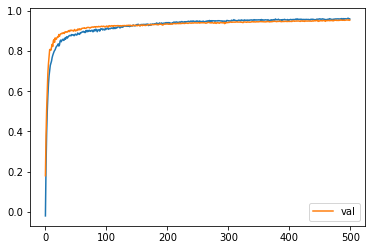

In [122]:
plt.plot(history.history['r2_score_nn'])
plt.plot(history.history['val_r2_score_nn'], label="val")
plt.legend()
#plt.xlim(50,100)

#plt.ylim(0.0, 0.025)
print(f"max val_r2 {np.max(history.history['val_r2_score_nn'])}")

### Gjennomføre en tes 
Henter helt nye data for å gjennomføre en test på modellen.

In [16]:
filer = list(map(add_data, os.listdir('data/')))[55:60] # test 54:60
data_test = make_ready().use_stockstats(filer)
dataxes, datayes = prepare_data_for_test(data_test)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
C:\Users\Stian\anaconda3\lib\site-packages\ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [17]:
dataxes.shape

(5,)

In [123]:
pred = []
#for x in val_x_set:
pred = (model.predict(val_x_set))

pred = np.array(pred)

In [124]:
pred.shape == val_y_set.shape

True

In [125]:
#for i in range(len(pred)):
print(f"rscore for one of it {r2_score(pred, val_y_set)}")
    

rscore for one of it 0.3166586030916001


In [106]:
j

234

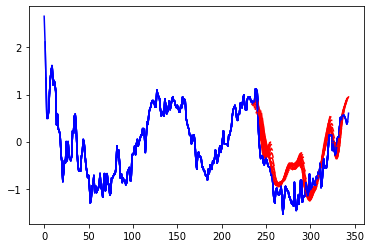

In [127]:
fig = plt.figure()
for j,i in enumerate(train_y_set):
    plt.plot(range(j, j+10), i, c='blue')

for i,x in enumerate(pred):
    plt.plot(range(j + i, j+ i+10), pred[i], c="red")
    plt.plot(range(j +i, j + i+10), val_y_set[i], c="blue")
    

In [131]:
fig.savefig('treneformiddag.png')

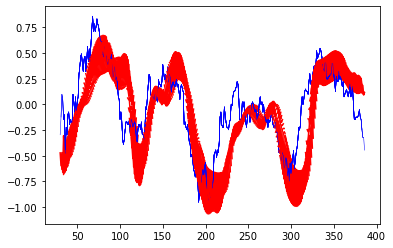

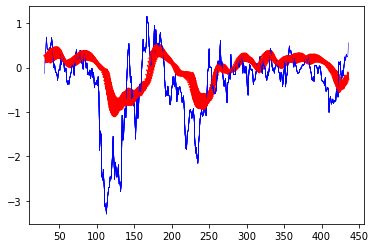

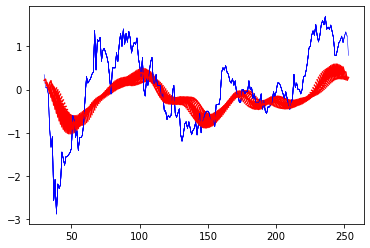

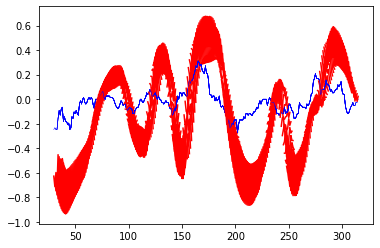

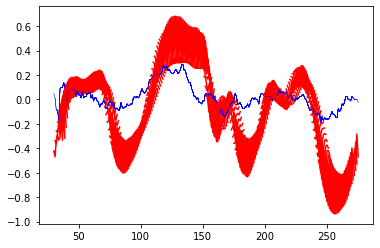

In [20]:
for i, p in enumerate(pred):
    for j, y in enumerate(p):
        
    #print(p.shape)
        plt.plot(range(30+j,40+j), datayes[i][j], c='blue', linewidth=.5)
        plt.plot(range(30+j,40+j), y, c='red')
    plt.show()

In [ ]:
plt.plot(data[0]['open'])

## Save model

In [ ]:
# Save model

model.save('models/rnn_model.h5')

In [ ]:
!dir